# Advance Driver Assistance System
Team 72

## Importing Libraries

In [1]:
import cv2
import numpy as np
import os
from scipy import optimize
from matplotlib import pyplot as plt, cm, colors
from time import gmtime, strftime
import geocoder
import requests
from bs4 import BeautifulSoup

In [2]:
# Defining variables to hold meter-to-pixel conversion
ym_per_pix = 30 / 720
# Standard lane width is 3.7 meters divided by lane width in pixels which is
# calculated to be approximately 720 pixels not to be confused with frame height
xm_per_pix = 3.7 / 720

# Get path to the current working directory
CWD_PATH = os.getcwd()

## Function to Read Image

In [3]:
def readVideo():

    # Read input video from current working directory
    inpImage = cv2.VideoCapture(os.path.join(CWD_PATH, 'videos/project_video.mp4'))

    return inpImage

## Process The Image

In [4]:
def processImage(inpImage):

    # Apply HLS color filtering to filter out white lane lines
    hls = cv2.cvtColor(inpImage, cv2.COLOR_BGR2HLS)
    lower_white = np.array([0, 160, 10])
    upper_white = np.array([255, 255, 255])
    mask = cv2.inRange(inpImage, lower_white, upper_white)
    hls_result = cv2.bitwise_and(inpImage, inpImage, mask = mask)

    # Convert image to grayscale, apply threshold, blur & extract edges
    gray = cv2.cvtColor(hls_result, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
    blur = cv2.GaussianBlur(thresh,(3, 3), 0)
    canny = cv2.Canny(blur, 40, 60)

    # Display the processed images
    # cv2.imshow("Image", inpImage)
    # cv2.imshow("HLS Filtered", hls_result)
    # cv2.imshow("Grayscale", gray)
    # cv2.imshow("Thresholded", thresh)
    # cv2.imshow("Blurred", blur)
    # cv2.imshow("Canny Edges", canny)

    return image, hls_result, gray, thresh, blur, canny

## Applying Perspective Warp

In [5]:
def perspectiveWarp(inpImage):

    # Get image size
    img_size = (inpImage.shape[1], inpImage.shape[0])

    # Perspective points to be warped
    src = np.float32([[590, 440],
                      [690, 440],
                      [200, 640],
                      [1000, 640]])

    # Window to be shown
    dst = np.float32([[200, 0],
                      [1200, 0],
                      [200, 710],
                      [1200, 710]])

    # Matrix to warp the image for birdseye window
    matrix = cv2.getPerspectiveTransform(src, dst)
    # Inverse matrix to unwarp the image for final window
    minv = cv2.getPerspectiveTransform(dst, src)
    birdseye = cv2.warpPerspective(inpImage, matrix, img_size)

    # Get the birdseye window dimensions
    height, width = birdseye.shape[:2]

    # Divide the birdseye view into 2 halves to separate left & right lanes
    birdseyeLeft  = birdseye[0:height, 0:width // 2]
    birdseyeRight = birdseye[0:height, width // 2:width]

    # Display birdseye view image
    #cv2.imshow("Birdseye" , birdseye)
    #cv2.imshow("Birdseye Left" , birdseyeLeft)
    #cv2.imshow("Birdseye Right", birdseyeRight)

    return birdseye, birdseyeLeft, birdseyeRight, minv

## Histogram of Warped Image

In [6]:
def plotHistogram(inpImage):

    histogram = np.sum(inpImage[inpImage.shape[0] // 2:, :], axis = 0)

    midpoint = np.int32(histogram.shape[0] / 2)
    leftxBase = np.argmax(histogram[:midpoint])
    rightxBase = np.argmax(histogram[midpoint:]) + midpoint

    plt.xlabel("Image X Coordinates")
    plt.ylabel("Number of White Pixels")

    # Return histogram and x-coordinates of left & right lanes to calculate
    # lane width in pixels
    return histogram, leftxBase, rightxBase

## APPLY SLIDING WINDOW METHOD TO DETECT CURVES

In [7]:
def slide_window_search(binary_warped, histogram):

    # Find the start of left and right lane lines using histogram info
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    midpoint = np.int32(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # A total of 9 windows will be used
    nwindows = 9
    window_height = np.int32(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    #### START - Loop to iterate through windows and search for lane lines #####
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high),
        (0,255,0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int32(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int32(np.mean(nonzerox[good_right_inds]))
    #### END - Loop to iterate through windows and search for lane lines #######

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Apply 2nd degree polynomial fit to fit curves
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    ltx = np.trunc(left_fitx)
    rtx = np.trunc(right_fitx)
    plt.plot(right_fitx)
    #plt.show()

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # plt.imshow(out_img)
    plt.plot(left_fitx,  ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    return ploty, left_fit, right_fit, ltx, rtx

## APPLY GENERAL SEARCH METHOD TO DETECT CURVES

In [8]:
def general_search(binary_warped, left_fit, right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
    left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    ## VISUALIZATION 

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    plt.imshow(result)
    plt.plot(left_fitx,  ploty, color = 'yellow')
    plt.plot(right_fitx, ploty, color = 'yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    ret = {}
    ret['leftx'] = leftx
    ret['rightx'] = rightx
    ret['left_fitx'] = left_fitx
    ret['right_fitx'] = right_fitx
    ret['ploty'] = ploty

    return ret

##  MEASURE CURVE RADIUS

In [9]:
def measure_lane_curvature(ploty, leftx, rightx):

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x, y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')

    # Decide if it is a left or a right curve
    if leftx[0] - leftx[-1] > 60:
        curve_direction = 'Left Curve'
    elif leftx[-1] - leftx[0] > 60:
        curve_direction = 'Right Curve'
    else:
        curve_direction = 'Straight'

    return (left_curverad + right_curverad) / 2.0, curve_direction

## SHOW DETECTED LANES AREA

In [10]:
def draw_lane_lines(original_image, warped_image, Minv, draw_info):

    leftx = draw_info['leftx']
    rightx = draw_info['rightx']
    left_fitx = draw_info['left_fitx']
    right_fitx = draw_info['right_fitx']
    ploty = draw_info['ploty']

    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    mean_x = np.mean((left_fitx, right_fitx), axis=0)
    pts_mean = np.array([np.flipud(np.transpose(np.vstack([mean_x, ploty])))])

    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(color_warp, np.int_([pts_mean]), (0, 255, 255))

    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0]))
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)

    return pts_mean, result

## CALCULATE DEVIATION FROM LANE CENTER

In [11]:
def offCenter(meanPts, inpFrame):

    # Calculating deviation in meters
    mpts = meanPts[-1][-1][-2].astype(int)
    pixelDeviation = inpFrame.shape[1] / 2 - abs(mpts)
    deviation = pixelDeviation * xm_per_pix
    direction = "left" if deviation < 0 else "right"

    return deviation, direction

## FUNCTION TO ADD INFO TEXT TO FINAL IMAGE

In [12]:
def addText(img, radius, direction, deviation, devDirection):

    # Add the radius and center position to the image
    font = cv2.FONT_HERSHEY_TRIPLEX
      

    if (direction != 'Straight'):
        text = 'Radius of Curve: ' + '{:04.0f}'.format(radius) + 'm'
        text1 = 'Curve Direction: ' + (direction)

    else:
        text = 'Radius of Curve: ' + 'N/A'
        text1 = 'Curve Direction: ' + (direction)         
            

    cv2.putText(img, text , (800,50), font, 0.8, (0,255, 0), 1, cv2.LINE_AA)
    cv2.putText(img, text1, (800,100), font, 0.8, (0,255, 0), 1, cv2.LINE_AA)

    # Deviation
    deviation_text = 'Off Center: ' + str(round(abs(deviation), 3)) + 'm' + ' to the ' + devDirection
    cv2.putText(img, deviation_text, (800, 150), cv2.FONT_HERSHEY_TRIPLEX, 0.8, (0,255, 0), 1, cv2.LINE_AA)

     # dashboard
    #lft = cv2.imread("direction_img/left_turn.png")
    #ri8 = cv2.imread("direction_img/right_turn.png")
    # stg = cv2.imread("direction_img/stright.png")
    
    
    
    
    shapes = np.zeros_like(img, np.uint8)
    cv2.rectangle(shapes, (775, 10), (1270, 180), (255,255,255), cv2.FILLED)
    
    out = img.copy()
    alpha = 0.5
    mask = shapes.astype(bool)
    out[mask] = cv2.addWeighted(img, alpha, shapes, 1 - alpha, 0)[mask]
    
        
    
    
    
    

    return out


In [13]:
'''# direction---------
    if direction == 'Left':
        overlay_img1 = np.ones(out.shape,np.uint8)*255

        img2 = cv2.imread('direction_img/left_turn.png')
        rows,cols,channels = img2.shape
        overlay_img1[450:rows+450, 450:cols+450 ] = img2

        img2gray = cv2.cvtColor(overlay_img1,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray,220,55,cv2.THRESH_BINARY_INV)
        mask_inv = cv2.bitwise_not(mask)
        temp1 = cv2.bitwise_and(out,out,mask = mask_inv)
        temp2 = cv2.bitwise_and(overlay_img1,overlay_img1, mask = mask)

        result = cv2.add(temp1,temp2)
    elif direction == 'Right':
        overlay_img1 = np.ones(out.shape,np.uint8)*255

        img2 = cv2.imread('direction_img/right_turn.png')
        rows,cols,channels = img2.shape
        overlay_img1[450:rows+450, 450:cols+450 ] = img2

        img2gray = cv2.cvtColor(overlay_img1,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray,220,55,cv2.THRESH_BINARY_INV)
        mask_inv = cv2.bitwise_not(mask)
        temp1 = cv2.bitwise_and(out,out,mask = mask_inv)
        temp2 = cv2.bitwise_and(overlay_img1,overlay_img1, mask = mask)

        result = cv2.add(temp1,temp2)
    else:
        overlay_img1 = np.ones(out.shape,np.uint8)*255

        img2 = cv2.imread('direction_img/stright.png')
        rows,cols,channels = img2.shape
        overlay_img1[450:rows+450, 450:cols+450 ] = img2

        img2gray = cv2.cvtColor(overlay_img1,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray,220,55,cv2.THRESH_BINARY_INV)
        mask_inv = cv2.bitwise_not(mask)
        temp1 = cv2.bitwise_and(out,out,mask = mask_inv)
        temp2 = cv2.bitwise_and(overlay_img1,overlay_img1, mask = mask)

        result = cv2.add(temp1,temp2)'''

"# direction---------\n    if direction == 'Left':\n        overlay_img1 = np.ones(out.shape,np.uint8)*255\n\n        img2 = cv2.imread('direction_img/left_turn.png')\n        rows,cols,channels = img2.shape\n        overlay_img1[450:rows+450, 450:cols+450 ] = img2\n\n        img2gray = cv2.cvtColor(overlay_img1,cv2.COLOR_BGR2GRAY)\n        ret, mask = cv2.threshold(img2gray,220,55,cv2.THRESH_BINARY_INV)\n        mask_inv = cv2.bitwise_not(mask)\n        temp1 = cv2.bitwise_and(out,out,mask = mask_inv)\n        temp2 = cv2.bitwise_and(overlay_img1,overlay_img1, mask = mask)\n\n        result = cv2.add(temp1,temp2)\n    elif direction == 'Right':\n        overlay_img1 = np.ones(out.shape,np.uint8)*255\n\n        img2 = cv2.imread('direction_img/right_turn.png')\n        rows,cols,channels = img2.shape\n        overlay_img1[450:rows+450, 450:cols+450 ] = img2\n\n        img2gray = cv2.cvtColor(overlay_img1,cv2.COLOR_BGR2GRAY)\n        ret, mask = cv2.threshold(img2gray,220,55,cv2.THRESH_

## Car Detection

In [14]:
def car_detection(img):
    grey = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(grey,(5,5),0)
    dilated = cv2.dilate(blur,np.ones((3,3)))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel) 
    car_cascade_src = 'cars.xml'
    car_cascade = cv2.CascadeClassifier(car_cascade_src)
    cars = car_cascade.detectMultiScale(closing, 1.1, 1)
    cnt = 0
    for (x,y,w,h) in cars:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        cnt += 1
    return frame

## Main Funtion

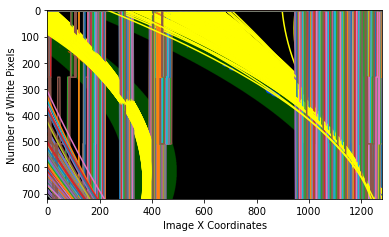

In [14]:
# START - MAIN FUNCTION 

# Read the input image
image = readVideo()

while True:

    _, frame = image.read()


    
    birdView, birdViewL, birdViewR, minverse = perspectiveWarp(frame)


    # Apply image processing by calling the "processImage()" function
    # Then assign their respective variables (img, hls, grayscale, thresh, blur, canny)
    # Provide this function with:
    # 1- an already perspective warped image to process (birdView)
    img, hls, grayscale, thresh, blur, canny = processImage(birdView)
    imgL, hlsL, grayscaleL, threshL, blurL, cannyL = processImage(birdViewL)
    imgR, hlsR, grayscaleR, threshR, blurR, cannyR = processImage(birdViewR)


    # Plot and display the histogram by calling the "get_histogram()" function
    # Provide this function with:
    # 1- an image to calculate histogram on (thresh)
    hist, leftBase, rightBase = plotHistogram(thresh)
    # print(rightBase - leftBase)
    plt.plot(hist)
    # plt.show()


    ploty, left_fit, right_fit, left_fitx, right_fitx = slide_window_search(thresh, hist)
    plt.plot(left_fit)
    # plt.show()


    draw_info = general_search(thresh, left_fit, right_fit)
    # plt.show()


    curveRad, curveDir = measure_lane_curvature(ploty, left_fitx, right_fitx)


    # Filling the area of detected lanes with green
    meanPts, result = draw_lane_lines(frame, thresh, minverse, draw_info)


    deviation, directionDev = offCenter(meanPts, frame)


    # Adding text to our final image
    finalImg = addText(result, curveRad, curveDir, deviation, directionDev)
    # Car detection
    # finalIm = car_detection(finalImg)

    
    
    
    # Displaying final image
    cv2.imshow("Final", finalImg)


    # Wait for the  key to be pressed to stop playback
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

# Cleanup
image.release()
cv2.destroyAllWindows()
